# Auto Regressive Time Series
First we start with some basic imports and set some defaults. For the most part we use the classes defined under endochrone/arima for fitting these models. Statsmodels provides a useful API for generating data. We won't use it for making predictions.

In [183]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_process import arma_generate_sample

import sys; sys.path.insert(0, '..')
from endochrone.correlation import acf, pacf
from endochrone.arima import ArModel, MaModel

plt.rc('figure', figsize=(20.0, 10.0))

### AR1
First we generate some well-behaved data which we can use to for modelling. We define a partial function purely for convenience as we'll want to generate more data for testing according to the same paramaters

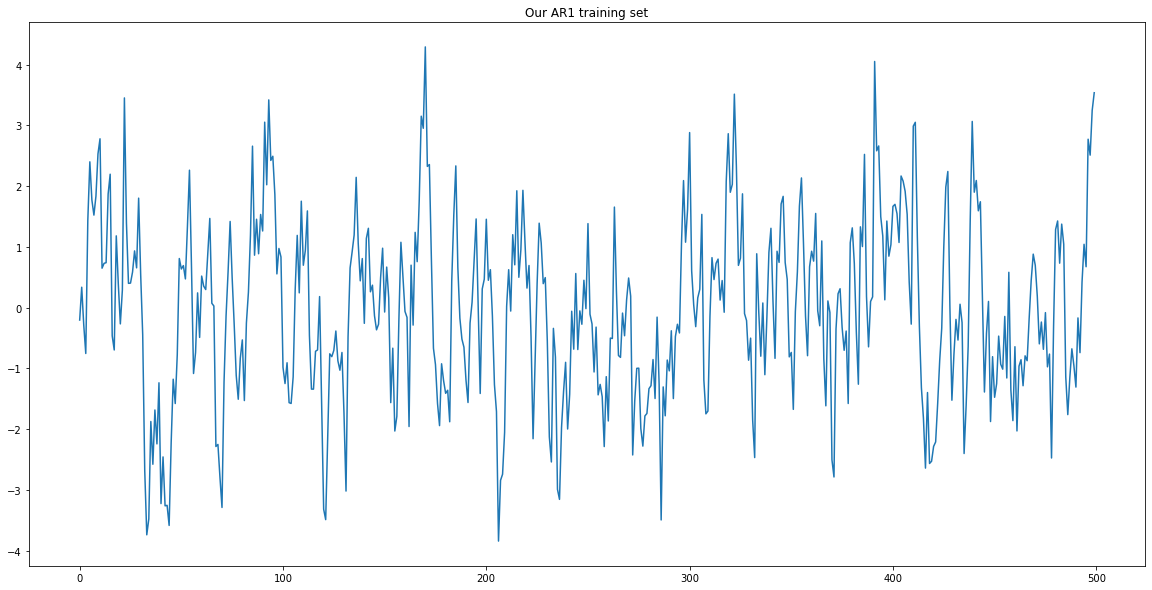

In [184]:
np.random.seed(seed=12345)
arma1_func = partial(arma_generate_sample, [1, -0.7], [1], scale=1)
N_train = 500
x = arma1_func(N_train)
plt.title("Our AR1 training set")
plt.plot(range(N_train), x);

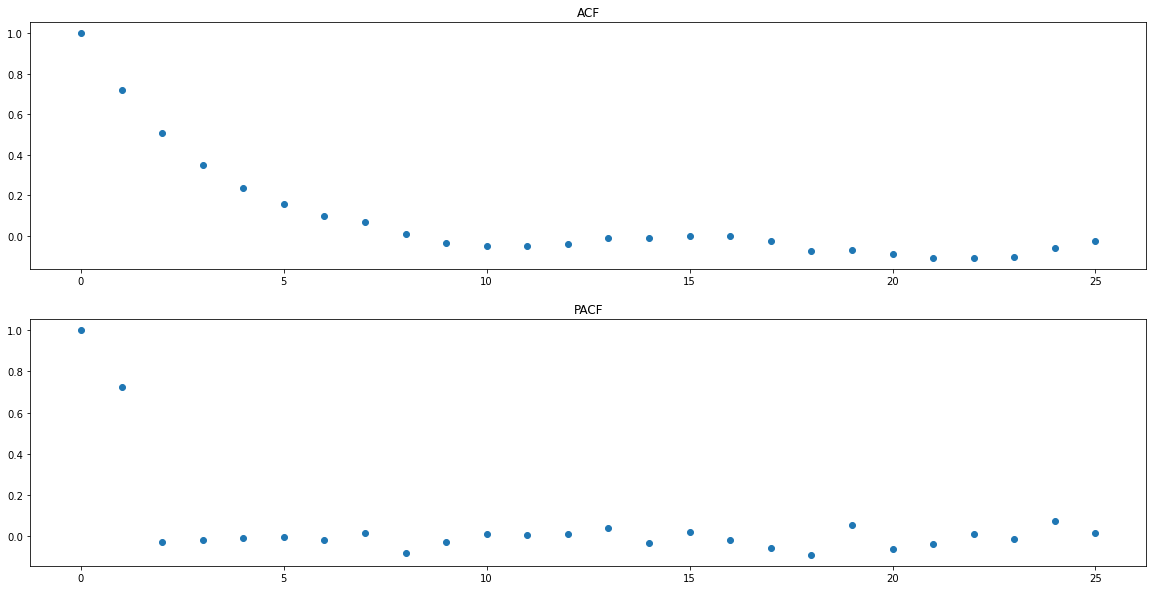

In [185]:
# First see if our acfs/pacfs show any correlations
n_lags = 25
ar1_acf = acf(x, lags=n_lags).values
ar1_pacf = pacf(x, lags=n_lags).values
fig1, a1 = plt.subplots(2,1)
fig1.size=(6,4)
a1[0].scatter(range(n_lags+1), ar1_acf)
a1[0].set_title('ACF')
a1[1].scatter(range(n_lags+1), ar1_pacf)
a1[1].set_title('PACF');

In particular we see the PACF decay after a single lag - suggesting an AR1 model may be a good fit (we knew this because we generated the data, but it was worth a check)

In [186]:
ar1 = ArModel(order=1, calculate_residuals=True)
ar1.fit(x)
print(ar1.intercept_)
print(ar1.coef_)

-0.007273228942837542
[0.72886015]


Which is pretty close. We'd expect our intercept to be around zero, and the coefficient to be 0.7. We should check our model correcly accounts for all expected correlation. We can do this by inspecting the residuals which we'd expect to be indistinguishable from noise

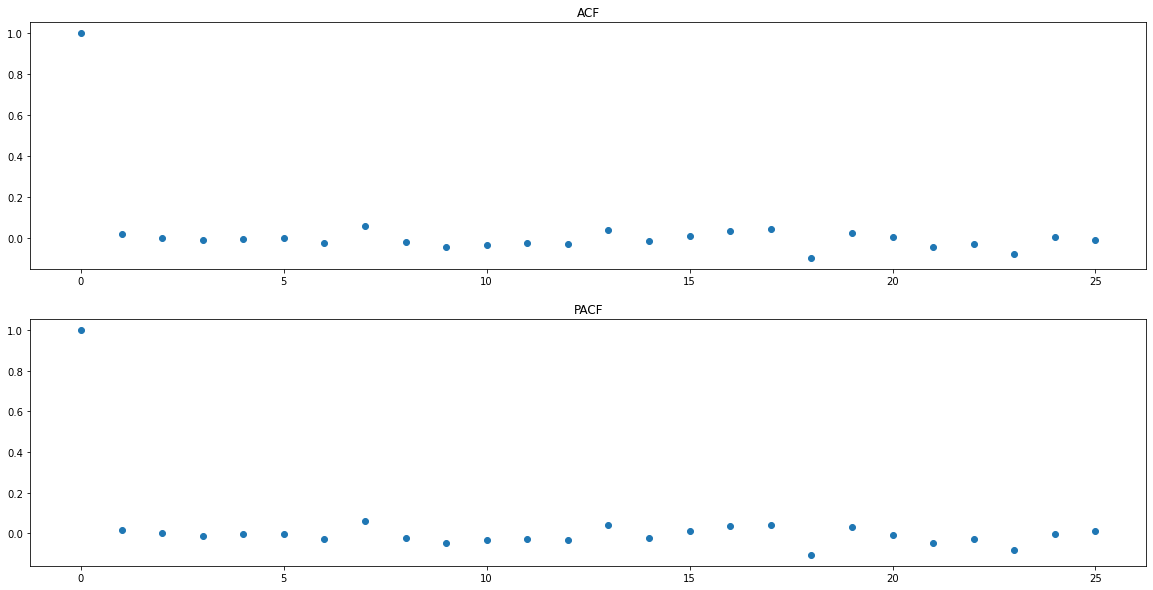

In [187]:
ar1_res = ar1.residuals_
n_lags = 25
ar1_res_acfs = acf(ar1_res, lags=n_lags).values
ar1_res_pacfs = pacf(ar1_res, lags=n_lags).values
fig, a = plt.subplots(2,1)
a[0].scatter(range(n_lags+1), ar1_res_acfs)
a[0].set_title('ACF')
a[1].scatter(range(n_lags+1), ar1_res_pacfs)
a[1].set_title('PACF');

Mean Sq Error: 1.0297346115135546
Mean of residuals: -7.475650025532116e-17
Variance of residuals: 1.0297346115135544


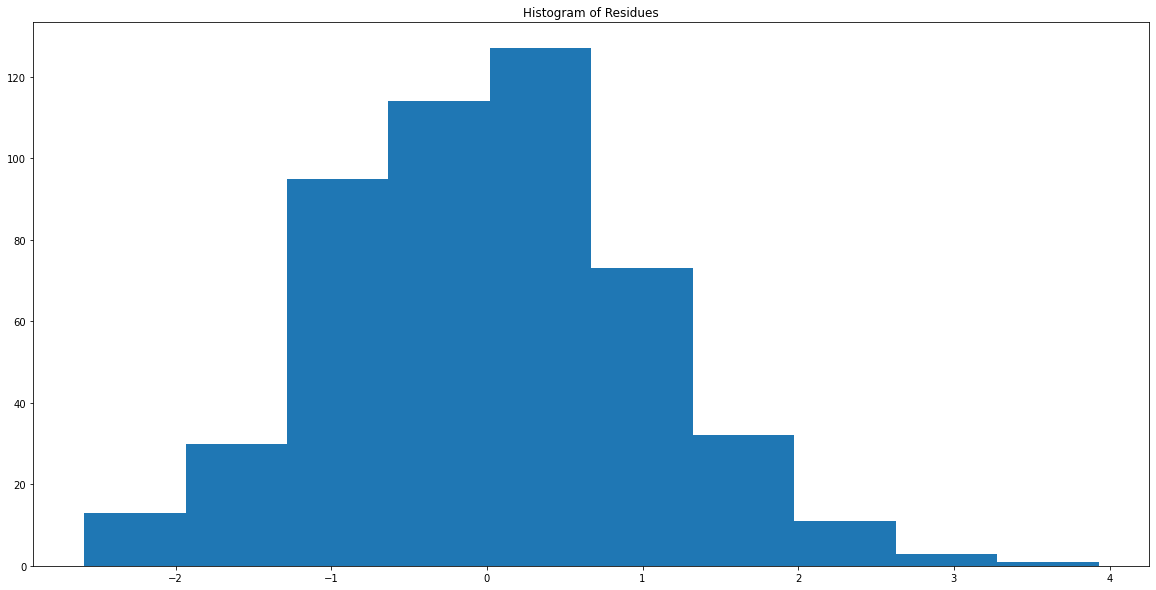

In [188]:
print('Mean Sq Error:', np.mean(ar1_res**2))
print('Mean of residuals:', np.mean(ar1_res))
print('Variance of residuals:', np.var(ar1_res))
plt.title('Histogram of Residues');
plt.hist(ar1_res, bins=10);

Now lets see how we do against some new data generated according to the same profile. (NB. We do this stepwise - we aren't predicting 30 steps out, we predict each step by looking at the previous correct answer.)

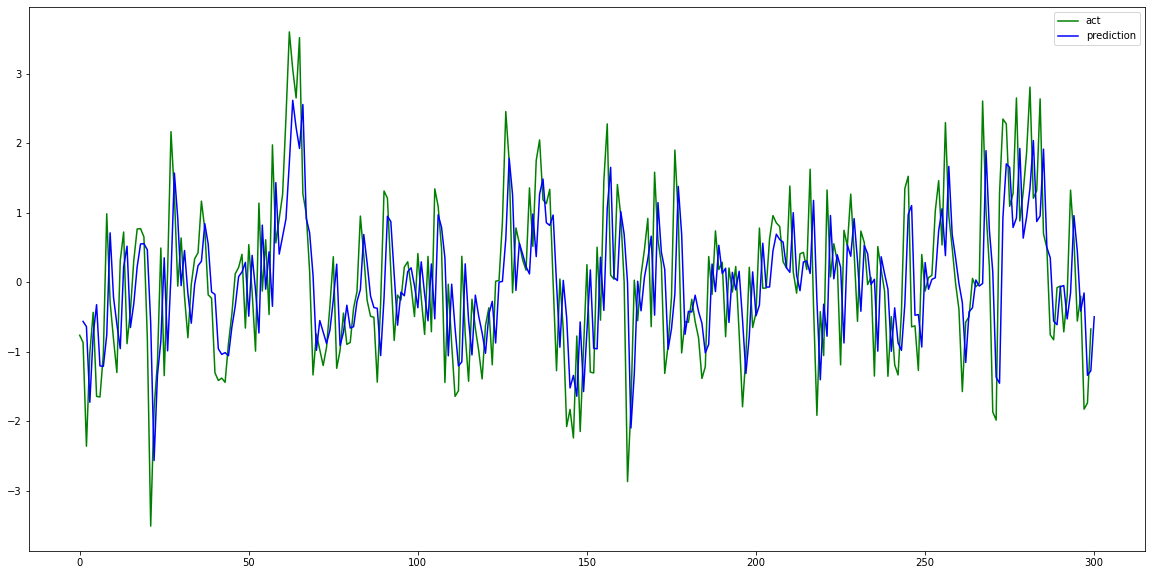

In [189]:
N_test = 300
y = arma1_func(N_test)
y_pred = ar1.predict(y)

plt.plot(range(N_test), y, c='green', label='act')
plt.plot(range(1, N_test+1), y_pred, c='blue', label='prediction')
plt.legend();

In [190]:
ar1_errs = y[1:] - y_pred[:-1]
print('Mean Sq Error:', np.mean(ar1_errs**2))
print('Mean Error:', np.mean(ar1_errs))
print('Var Error:', np.var(ar1_errs))

Mean Sq Error: 0.9141500202503796
Mean Error: 0.014518346557527689
Var Error: 0.9139392378636151


### AR30
Let's try a slightly more complex model. This time we'll add values for the 7th and 28th cycle to simulate a weekly & 4-weekly cycle

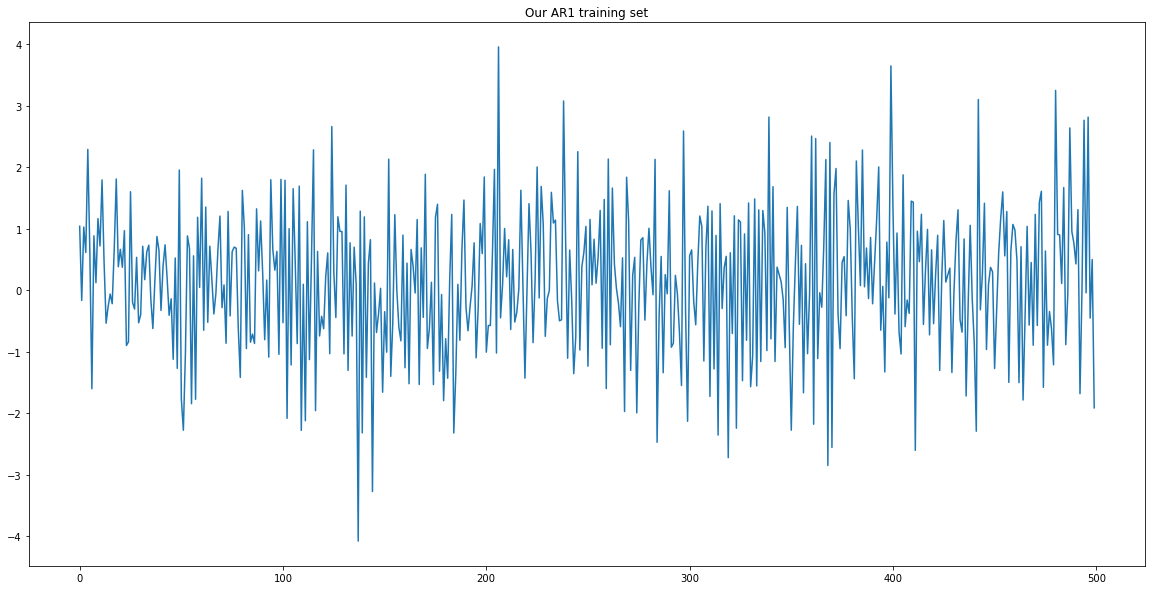

In [191]:
np.random.seed(seed=123455)
corrs = [1, 0.25] + 5*[0] + [-0.4] + 20*[0] + [-0.3]
arma2_func = partial(arma_generate_sample, corrs, [1], scale=1)
N_train = 5000
x2 = arma2_func(N_train)
plt.title("Our AR1 training set")
plt.plot(range(500), x2[:500]);

There's too many terms to be able to see much but hopefully the ACF & PACF will ratify the behaviour we expect

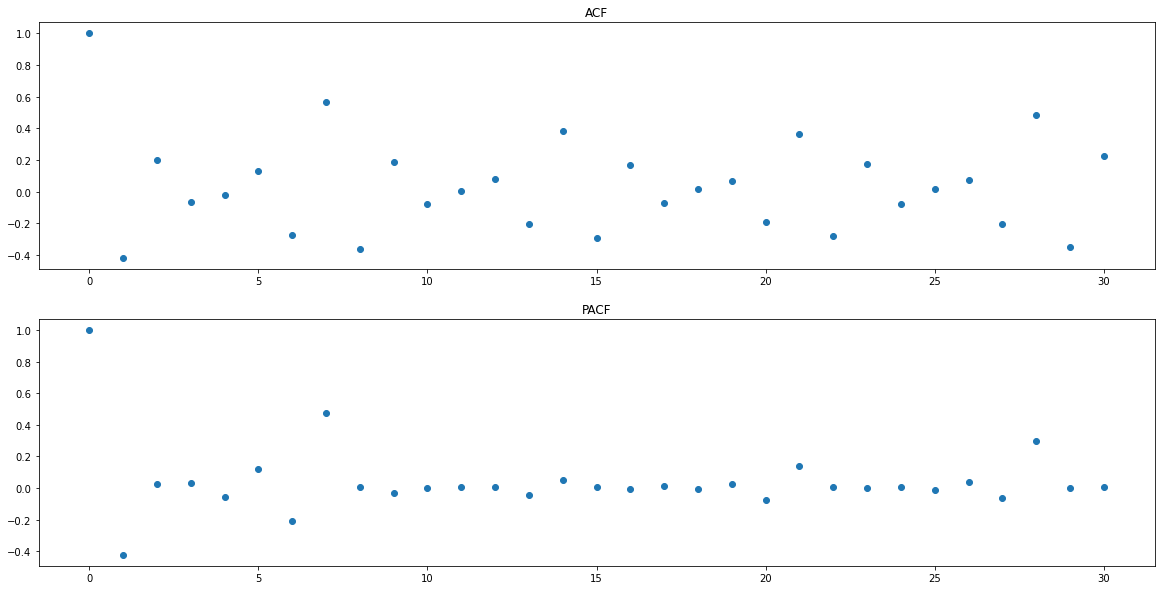

In [192]:
n_lags = 30
ar2_acf = acf(x2, lags=n_lags).values
ar2_pacf = pacf(x2, lags=n_lags).values
fig2, a2 = plt.subplots(2,1)
fig2.size=(6,4)
a2[0].scatter(range(n_lags+1), ar2_acf)
a2[0].set_title('ACF')
a2[1].scatter(range(n_lags+1), ar2_pacf)
a2[1].set_title('PACF');

Indeed we see cycles on a weekly basis, as well as a larger pattern every 28 days. Let's fit our model. We'll plot our coefficients as it's easier to see which ones are far from zero

0.005842216812302724


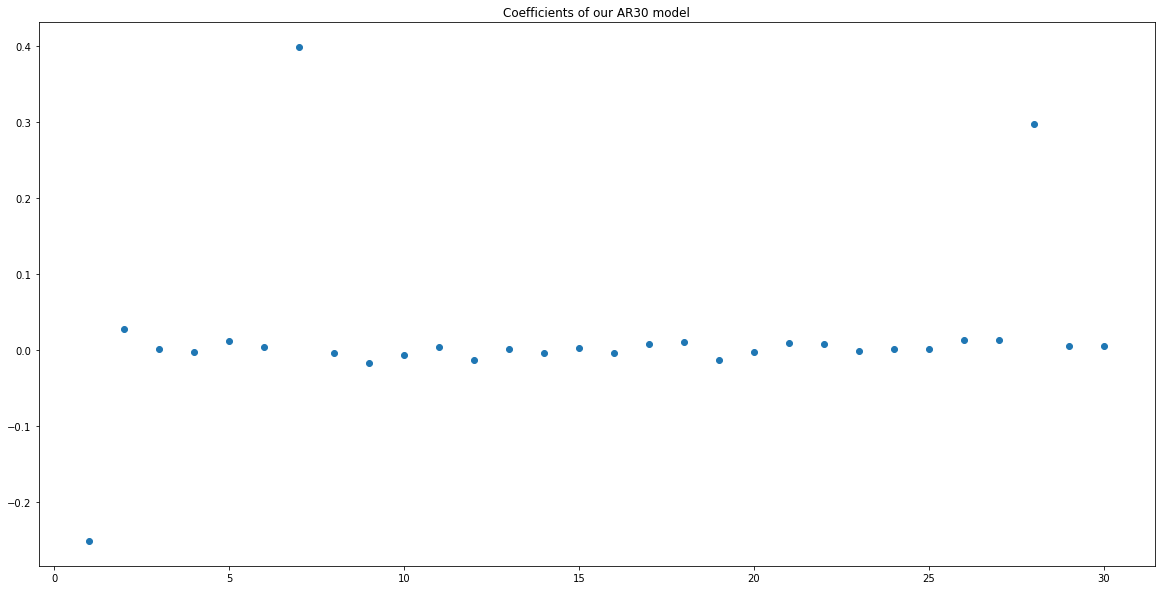

In [193]:
ar2 = ArModel(order=30, calculate_residuals=True)
ar2.fit(x2)
print(ar2.intercept_)
plt.scatter(range(1,31), ar2.coef_);
plt.title("Coefficients of our AR30 model");

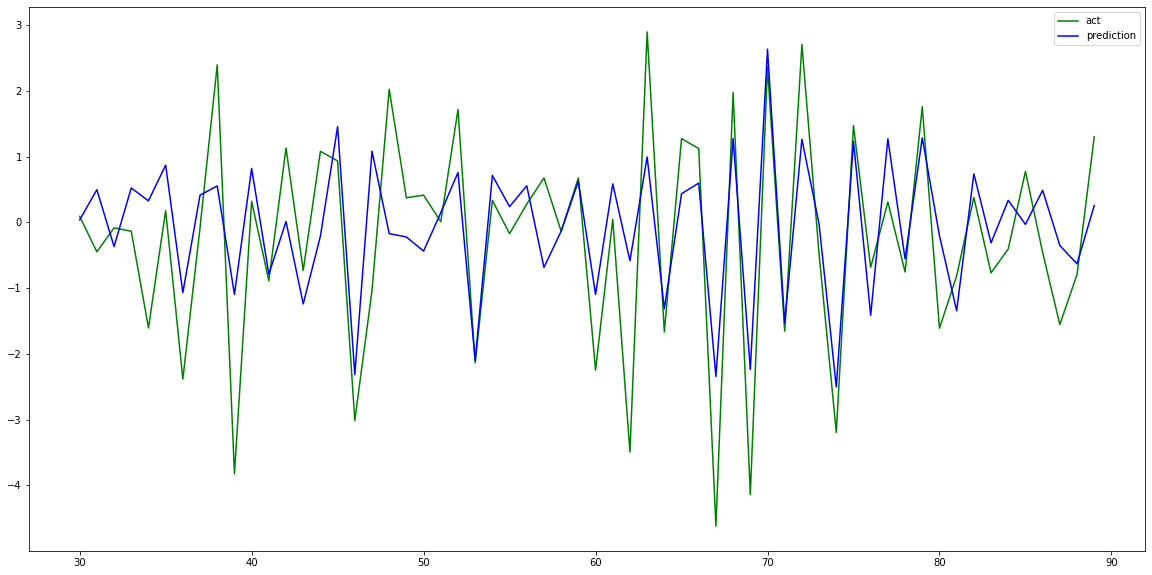

In [194]:
N_test = 300
y2 = arma2_func(N_test)
y2_pred = ar2.predict(y2)

plt.plot(range(30, 90), y2[30:90], c='green', label='act')
plt.plot(range(30, 90), y2_pred[:60], c='blue', label='prediction')
plt.legend();

Though we predicted 271 points, only 60 are shown in the graph - more than that and it's a little hard to see the cycling. Let's finally compare our errors:

In [195]:
print('MSE(Training): %06f' % np.mean(ar2.residuals_**2))
ar2_errs = y2[30:] - y2_pred[:-1]
print('MSE(Forecast): %06f' % np.mean(ar2_errs**2))

MSE(Training): 0.997811
MSE(Forecast): 1.027536


This is about what we'd expect as it's the variance of our white noise.